# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 7.4MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Thu May 20 11:48:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc',
 'question_pair']

In [ ]:
kowiki_dir = os.path.join(data_dir, "kowiki")
if not os.path.isdir(kowiki_dir):
    os.makedirs(kowiki_dir)
os.listdir(kowiki_dir)

['kowiki.txt.zip',
 'kowiki_32000.vocab',
 'kowiki_32000.model',
 'kowiki_mecab_32000.vocab',
 'kowiki_mecab_32000.model',
 'nsmc']

# Tutorial

In [ ]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해',
    '나는 오늘 행복해 나는 오늘 즐거워'
]

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())
words

['나는',
 '오늘',
 '기분이',
 '좋아',
 '나는',
 '오늘',
 '우울해',
 '나는',
 '오늘',
 '행복해',
 '나는',
 '오늘',
 '즐거워']

In [ ]:
# 중복 단어 제거
words = list(dict.fromkeys(words))
words

['나는', '오늘', '기분이', '좋아', '우울해', '행복해', '즐거워']

In [ ]:
# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

{'[BOS]': 2,
 '[EOS]': 3,
 '[PAD]': 0,
 '[UNK]': 1,
 '기분이': 6,
 '나는': 4,
 '오늘': 5,
 '우울해': 8,
 '좋아': 7,
 '즐거워': 10,
 '행복해': 9}

In [ ]:

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

id_to_word
# word_to_id 

{0: '[PAD]',
 1: '[UNK]',
 2: '[BOS]',
 3: '[EOS]',
 4: '나는',
 5: '오늘',
 6: '기분이',
 7: '좋아',
 8: '우울해',
 9: '행복해',
 10: '즐거워'}

In [ ]:
# 학습용 입력 데이터 생성
train_ids = []
for sentence in sentences:
    train_ids.append([word for word in sentence.split()])

train_ids

[['나는', '오늘', '기분이', '좋아', '나는', '오늘', '우울해'],
 ['나는', '오늘', '행복해', '나는', '오늘', '즐거워']]

In [ ]:

# id를 입력과 정답으로 저장
train_inputs, train_labels = [], []
for train_id in train_ids:
    train_inputs.append([word_to_id['[BOS]']] + train_id)
    train_labels.append(train_id + [word_to_id['[EOS]']])

train_inputs, train_labels

([[2, 4, 5, 6, 7, 4, 5, 8], [2, 4, 5, 9, 4, 5, 10]],
 [[4, 5, 6, 7, 4, 5, 8, 3], [4, 5, 9, 4, 5, 10, 3]])

In [ ]:
# 학습용 입력 데이터 생성
# 숫자로 보자
train_ids = []
for sentence in sentences:
    train_ids.append([word_to_id[word] for word in sentence.split()])

train_ids

[[4, 5, 6, 7, 4, 5, 8], [4, 5, 9, 4, 5, 10]]

In [ ]:
# id를 입력과 정답으로 저장
# 숫자로 보자

train_inputs, train_labels = [], []
for train_id in train_ids:
    train_inputs.append([word_to_id['[BOS]']] + train_id)
    train_labels.append(train_id + [word_to_id['[EOS]']])

train_inputs, train_labels

([[2, 4, 5, 6, 7, 4, 5, 8], [2, 4, 5, 9, 4, 5, 10]],
 [[4, 5, 6, 7, 4, 5, 8, 3], [4, 5, 9, 4, 5, 10, 3]])

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 8)
# padding을 뒤로 할게

for row in train_inputs:
    row += [0] * (8 - len(row))
train_inputs

[[2, 4, 5, 6, 7, 4, 5, 8], [2, 4, 5, 9, 4, 5, 10, 0]]

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 8)
# label도 마찬가지로 padding을 뒤로 할게

for row in train_labels:
    row += [0] * (8 - len(row))
train_labels

[[4, 5, 6, 7, 4, 5, 8, 3], [4, 5, 9, 4, 5, 10, 3, 0]]

In [ ]:


# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)
train_labels = np.array(train_labels)

train_inputs, train_labels

(array([[ 2,  4,  5,  6,  7,  4,  5,  8],
        [ 2,  4,  5,  9,  4,  5, 10,  0]]),
 array([[ 4,  5,  6,  7,  4,  5,  8,  3],
        [ 4,  5,  9,  4,  5, 10,  3,  0]]))

In [ ]:
# 단어를 벡터로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 4) # 256도 가능하지만 지금은 4개로 할게 # 지금 깡통 만들어준거지
hidden = embedding(train_inputs)  # (bs, n_seq, 4)
hidden

<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.01826397, -0.03069841,  0.03251565,  0.00923193]],

       [[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.01256046,  0.0343336 , -0.02595751,  0.03221213],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.03375109, -0.02327753, -0.00871272,  0.00912046],
        [ 0.00380

In [ ]:
# LSTM 실행
lstm = tf.keras.layers.LSTM(units=3, return_sequences=True) # 단어별로 하니까 True하면 마지막 다 나오지
hidden = lstm(hidden)
hidden

<tf.Tensor: shape=(2, 8, 3), dtype=float32, numpy=
array([[[ 0.00263128,  0.00372436,  0.00347349],
        [ 0.00804141,  0.00799832,  0.00036361],
        [ 0.0055174 ,  0.00492641,  0.00126224],
        [ 0.0073576 ,  0.00173376,  0.00019006],
        [-0.00076542,  0.00425473, -0.00886119],
        [ 0.00367485,  0.00863113, -0.00975975],
        [ 0.00065831,  0.00550723, -0.00692214],
        [-0.00184034,  0.00622184, -0.00650281]],

       [[ 0.00263128,  0.00372436,  0.00347349],
        [ 0.00804141,  0.00799832,  0.00036361],
        [ 0.0055174 ,  0.00492641,  0.00126224],
        [ 0.01006418, -0.00509556,  0.00143652],
        [ 0.01388353,  0.00171788, -0.00189374],
        [ 0.01003195,  0.00042014, -0.00112339],
        [ 0.00520715, -0.00204564, -0.00557995],
        [-0.00061449,  0.00381689, -0.00534766]]], dtype=float32)>

In [ ]:
# 다음단어 예측
# 10개중 어떤게 높을지 보는거지
linear = tf.keras.layers.Dense(len(word_to_id), activation=tf.nn.softmax) # 다음단어를 예측해야되니까 vocab 수(size)만큼 공간 만들어 놓아야지
y_pred = linear(hidden)
y_pred

# 우리는 이제 y^을 구한거지
# random samping로 할지 greedy로 할지는맘대로
# 8개중 하나가 한 단어후에 나머지 9단어중 각각 나올 확률을 보여준거지


<tf.Tensor: shape=(2, 8, 11), dtype=float32, numpy=
array([[[0.09125815, 0.09128441, 0.09055494, 0.09074712, 0.09068543,
         0.09083486, 0.09090409, 0.09114875, 0.09071188, 0.09074899,
         0.09112138],
        [0.09143907, 0.0914532 , 0.09038852, 0.09057821, 0.0904419 ,
         0.0907717 , 0.09067754, 0.09123763, 0.09078959, 0.09078302,
         0.0914396 ],
        [0.09131733, 0.09130573, 0.09052559, 0.09068915, 0.09057495,
         0.09082845, 0.09080471, 0.09113048, 0.09080515, 0.09076311,
         0.09125536],
        [0.09133464, 0.09117477, 0.09062117, 0.09075246, 0.09053296,
         0.09092306, 0.09089886, 0.09093244, 0.09096558, 0.09065252,
         0.09121154],
        [0.09047181, 0.09065819, 0.09118348, 0.09087524, 0.09107007,
         0.09080084, 0.09045237, 0.09091865, 0.09110927, 0.09144552,
         0.09101456],
        [0.0907087 , 0.09090623, 0.09094498, 0.09070205, 0.09083209,
         0.09072699, 0.09029058, 0.09107286, 0.09108623, 0.09142371,
         0

In [ ]:
train_labels

array([[ 4,  5,  6,  7,  4,  5,  8,  3],
       [ 4,  5,  9,  4,  5, 10,  3,  0]])

In [ ]:
# CE loss
tf.keras.losses.SparseCategoricalCrossentropy()(train_labels, y_pred)
# 쉽게 one-hot 으로 바꾸는거지

<tf.Tensor: shape=(), dtype=float32, numpy=2.3987534>

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args

Namespace(d_model=32, n_vocab=11, seed=1234)

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((None,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model) # 베치사이즈.문장 단어갯수, 안에 size
    # LSTM
    lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True)
    hidden = lstm(hidden)  # (bs, n_seq, d_model)
    # 다음단어 확률 분포
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax)
    y_pred = linear(hidden)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

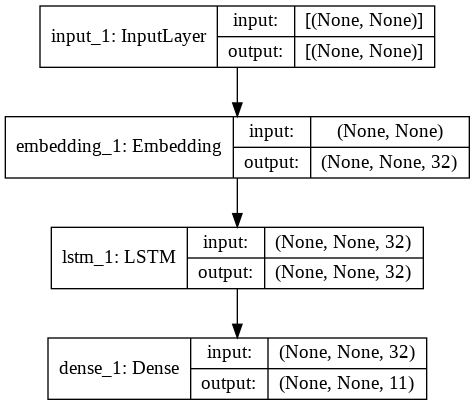

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs)

# Vocabulary*

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

# Data*

In [ ]:
kowiki_file = os.path.join(kowiki_dir, "kowiki.txt.zip")

In [ ]:
# count 확인(문장 갯수 확인)

count = 0
# wiki 내용 확인
with zipfile.ZipFile(kowiki_file) as z:
    with z.open("kowiki.txt") as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
        if line:
            count += 1
count
            # if  100 < i:
            #     break
            # line = line.decode('utf-8').strip()
            # print(line)

0

In [ ]:
# wiki 내용 100개만 확인
# 크롤링한 데이터지
# label 안된

with zipfile.ZipFile(kowiki_file) as z:
    with z.open("kowiki.txt") as f:
        for i, line in enumerate(f):
            if  100 < i:
                break
            line = line.decode('utf-8').strip()
            print(line)

지미 카터
제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.
1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.
1976년 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워, 포드를 누르고 당선되었다.
카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.
카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.
그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.
카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.
그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니스탄 침공 사건으로 인해 1980년 하계 올림픽에 반공국가들의 보이콧을 내세웠다.
지미 카터는 대한민국과의 관계에서도 중요한 영향을 미쳤던 대통

# Loss & Acc*

In [ ]:
# 3개 의 단어를 예측하기 위한 정답과 예측값 가정
# 정답
y_true = np.random.randint(1, 3, (1, 20)).astype(np.float32) # 1~2 까지 20개
y_true[:, 8:] = 0 # padding 값

# 예측 값
y_pred = np.random.random((1, 20, 4)).astype(np.float32)
y_pred = tf.nn.softmax(y_pred, axis=-1).numpy()  # 확률 값으로 변경

y_true, y_pred

(array([[2., 2., 1., 2., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32),
 array([[[0.2014149 , 0.2324197 , 0.27894443, 0.28722093],
         [0.24675597, 0.2986718 , 0.28180978, 0.17276245],
         [0.27507097, 0.30699873, 0.18292724, 0.2350031 ],
         [0.15437315, 0.20702003, 0.3639919 , 0.27461487],
         [0.21794166, 0.3223877 , 0.20111176, 0.25855887],
         [0.32595006, 0.21140806, 0.3048331 , 0.15780872],
         [0.25889552, 0.25897846, 0.15932652, 0.32279944],
         [0.24688567, 0.39390135, 0.16844238, 0.1907706 ],
         [0.1605852 , 0.30077136, 0.27757582, 0.26106766],
         [0.17876586, 0.30012107, 0.23803584, 0.2830772 ],
         [0.19547002, 0.3207642 , 0.3078022 , 0.17596352],
         [0.20055635, 0.26928666, 0.23845431, 0.29170266],
         [0.32548183, 0.2754673 , 0.1659615 , 0.23308931],
         [0.30148587, 0.22730768, 0.27395034, 0.19725615],
         [0.24169718, 0.41077352, 0.17416097, 0.17336829],

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    # loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred) # 축소시키지 말아라
    # mask = tf.not_equal(y_true, 0)
    # mask = tf.cast(mask, tf.float32)
    # print(mask)
    # loss *= mask
    return loss

In [ ]:
# lm_loss 함수 확인
loss = lm_loss(y_true, y_pred)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.4051585>

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred) # 축소시키지 말아라
    # mask = tf.not_equal(y_true, 0)
    # mask = tf.cast(mask, tf.float32)
    # print(mask)
    # loss *= mask
    return loss

In [ ]:
# lm_loss 함수 확인
loss = lm_loss(y_true, y_pred)
loss

# 8 이상부터 패드니까 이제 지워볼게

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[1.2767426, 1.266523 , 1.1809117, 1.0106237, 1.1320004, 1.553965 ,
        1.3510103, 1.7811615, 1.8289306, 1.7216785, 1.6323483, 1.60666  ,
        1.1224486, 1.1990322, 1.4200697, 1.1497062, 1.7085248, 1.7428582,
        1.1049249, 1.31305  ]], dtype=float32)>

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred) # 축소시키지 말아라
    mask = tf.not_equal(y_true, 0)
    # mask = tf.cast(mask, tf.float32)
    print(mask)
    # loss *= mask
    return loss

In [ ]:
# lm_loss 함수 확인
loss = lm_loss(y_true, y_pred)
loss

# 8 이상부터 패드니까 이제 지워볼게

tf.Tensor(
[[ True  True  True  True  True  True  True  True False False False False
  False False False False False False False False]], shape=(1, 20), dtype=bool)


<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[1.2767426, 1.266523 , 1.1809117, 1.0106237, 1.1320004, 1.553965 ,
        1.3510103, 1.7811615, 1.8289306, 1.7216785, 1.6323483, 1.60666  ,
        1.1224486, 1.1990322, 1.4200697, 1.1497062, 1.7085248, 1.7428582,
        1.1049249, 1.31305  ]], dtype=float32)>

In [ ]:
y_true

array([[2., 2., 1., 2., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred) # 축소시키지 말아라
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32) 
    # mask된거, 즉 수는 1로, padding값인 0은 0으로 즉,숫자로 바꿀게
    # 형을 변환해주는거야 tf.cast는 astype같은것처럼
    # 원래 True = 1, False = 0이였잖아! float32로 바꾸니까 1과 0으로 바뀐거지!
    
    print(mask)
    loss *= mask # 1은 그대로 값을 가져오고 0을 곱하면 당연히 0이 디니까
    return loss

In [ ]:
# lm_loss 함수 확인
loss = lm_loss(y_true, y_pred)
loss

# 결국엔 padding은 학습할 필요가 없으니 
# 0으로 바꿔줘서 효율을 높여준거지

# 뭐 0대신 2나 3같이 가중치를 더 줄수 잇겠지

tf.Tensor([[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 20), dtype=float32)


<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[1.2767426, 1.266523 , 1.1809117, 1.0106237, 1.1320004, 1.553965 ,
        1.3510103, 1.7811615, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       ]], dtype=float32)>

In [ ]:
# cross entropy랑 sparse croness entropy랑의 차이점

train_labels.shape

(2, 8)

In [ ]:
# y_pred.shape => (2,8,11)이라할때

# train label을 원핫으로 알아서 바꿔서 y_pred를 곱해준다=> sparse cross entropy
# 직접 one hot으로 돌려서 곱해준다 => entropy

# entropy는 one hot으로 들어가야 되고
# sparse는 숫자로 바로 들어가도 된다

(1, 20, 4)

In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

In [ ]:
# lm_acc 함수 확인
accuracy = lm_acc(y_true, y_pred)
print(accuracy)

tf.Tensor(0.375, shape=(), dtype=float32)


# Small Data Project

## Train 데이터 생성

In [ ]:
docs, doc = [], []
# wiki 내용 확인
with zipfile.ZipFile(kowiki_file) as z:
    with z.open("kowiki.txt") as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if line:
                doc.append(line)
            else:
                if doc:
                    docs.append(doc)
                doc = []
len(docs)   

In [ ]:
docs[3]

In [ ]:
docs_train = docs[:1]
docs_train

[['지미 카터',
  '제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.',
  '지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.',
  '1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.',
  '1976년 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워, 포드를 누르고 당선되었다.',
  '카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.',
  '카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.',
  '그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.',
  '카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.',
  '그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니스탄 침공 사건으로 인해 1980년 하계 올림픽에 반공국가

In [ ]:
def make_data(docs, vocab, n_seq):
    inputs, labels = [], []
    n_max = n_seq - 1

    for doc in tqdm(docs, total=len(docs)):
        chunk, chunk_len = [], 0
        for i, line in enumerate(doc):
            tokens = vocab.encode_as_ids(line)
            chunk.append(tokens)
            chunk_len += len(tokens)

            if n_max <= chunk_len or i >= len(doc) - 1:
                token_ids = []
                for tokens in chunk:
                    token_ids.extend(tokens)
                token_ids = token_ids[:n_max]

                input_id = [vocab.bos_id()] + token_ids
                input_id += [0] * (n_seq - len(input_id))
                inputs.append(input_id)

                label_id = token_ids + [vocab.eos_id()]
                label_id += [0] * (n_seq - len(label_id))
                labels.append(label_id)

                chunk, chunk_len = [], 0

    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(docs_train, vocab, 128)
train_inputs, train_labels

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args

Namespace(d_model=256, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((None,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    # LSTM
    lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True)
    hidden = lstm(hidden)  # (bs, n_seq, d_model * 2)
    # 다음단어 확률 분포
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax)
    y_pred = linear(hidden)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

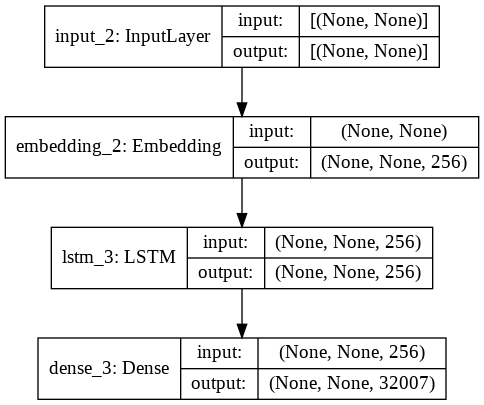

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs[:4])

## Train

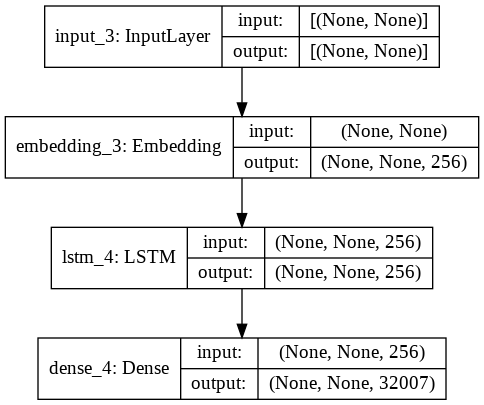

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=5)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kowiki_dir, "lm.hdf5"),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kowiki_dir, "lm.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 9.8349 - lm_acc: 0.0427

Epoch 00001: lm_acc improved from -inf to 0.04273, saving model to /content/drive/MyDrive/Data/nlp/kowiki/lm.hdf5
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 9.6323 - lm_acc: 0.0404

Epoch 00002: lm_acc did not improve from 0.04273
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 9.3800 - lm_acc: 0.0404

Epoch 00003: lm_acc did not improve from 0.04273
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 9.0912 - lm_acc: 0.0404

Epoch 00004: lm_acc did not improve from 0.04273
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 8.7696 - lm_acc: 0.0370

Epoch 00005: lm_acc did not improve from 0.04273
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 8.4140 - lm_acc: 0.0346

Epoch 00006: lm_acc did not improve from 0.04273


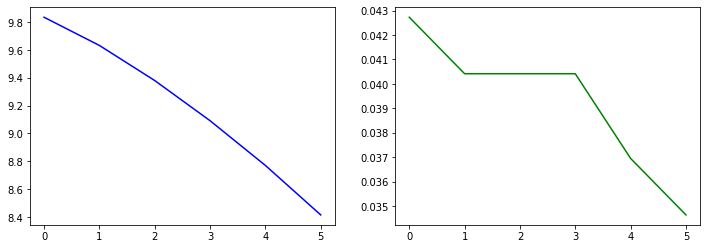

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(kowiki_dir, "lm.hdf5"))

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
valid_inputs = train_inputs[:100]
valid_labels = train_labels[:100]

In [ ]:
model.evaluate(valid_inputs, valid_labels, batch_size=128)

In [ ]:
y_pred = model.predict(valid_inputs)
y_pred

In [ ]:
y_true = tf.one_hot(valid_labels, args.n_vocab).numpy()
y_true[:, :, 0] = 0
y_true.shape, y_true

In [ ]:
y_prob1 = y_true * y_pred
y_prob1.shape, y_prob1

In [ ]:
y_prob2 = np.sum(y_prob1, axis=-1)
y_prob2.shape, y_prob2

In [ ]:
y_prob2[y_prob2 == 0] = 1
y_prob2.shape, y_prob2

In [ ]:
logppl1 = - np.log(y_prob2)
logppl1.shape, logppl1

In [ ]:
logppl = np.mean(logppl1)
logppl

In [ ]:
ppl = np.exp(logppl)
ppl

## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(kowiki_dir, "lm.hdf5"))

In [ ]:
def do_next(vocab, model, string):
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens]
    token_id = [vocab.bos_id()] + token_id

    result = model.predict(np.array([token_id]))
    prob = result[0][start_idx]
    max_args = np.argsort(prob)[-10:]
    max_args = list(max_args)
    max_args.reverse()

    next_prob = []
    for i in max_args:
        w = vocab.id_to_piece(int(i))
        p = prob[i]
        next_prob.append((w, p))
    return next_prob

In [ ]:
string = '대한민국'
do_next(vocab, model, string)

In [ ]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    next_prob = do_next(vocab, model, string)
    for w, p in next_prob:
        print(f'{w}: {p}')
    print()

In [ ]:
def do_generate(vocab, model, n_seq, string):
    n_max = n_seq - 1
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    for _ in range(start_idx, n_seq - 1):
        outputs = model.predict(np.array([token_id]))
        prob = outputs[0][start_idx]
        word_id = int(np.random.choice(len(vocab), 1, p=prob)[0])
        # word_id = int(np.argmax(prob))
        if word_id == vocab.eos_id():
            break
        token_id[start_idx + 1] = word_id
        start_idx += 1
    predict_id = token_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
string = '대한민국'
do_generate(vocab, model, 64, string)

In [ ]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_generate(vocab, model, 64, string)
    print(predict_str)

# All Data Project